In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib2tikz import save as tikz_save
# numpy (math) libary
import numpy as np

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

### import iterator
from modules.iterate import *

In [3]:
history = 4
error = 1e-6
maxit = 2e3
history_weight = 0.25

ω_size = 17
ω_range  = np.linspace(w2f(1.55035e-6)/ω0, w2f(1.55055e-6)/ω0, ω_size) # [Hz/ω0]
E_size = 64
#E_range = np.power(np.logspace(0, 1.2, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
E_range = np.power(np.linspace(10**0, 10**1.2, num=E_size, endpoint=False), 0.5) # [10^x mW/mW]
#E_range = np.power(np.logspace(1.03, 1.037, num=E_size, endpoint=True), 0.5) # [10^x mW/mW]
#E_range = np.power(np.append(np.logspace(-1, 1, num=E_size/2, endpoint=True),np.logspace(1.02, 1.05, num=E_size/2, endpoint=True)) , 0.5)
print(E_range**2)

[ 1.          1.23201456  1.46402912  1.69604368  1.92805825  2.16007281
  2.39208737  2.62410193  2.85611649  3.08813105  3.32014561  3.55216017
  3.78417474  4.0161893   4.24820386  4.48021842  4.71223298  4.94424754
  5.1762621   5.40827667  5.64029123  5.87230579  6.10432035  6.33633491
  6.56834947  6.80036403  7.03237859  7.26439316  7.49640772  7.72842228
  7.96043684  8.1924514   8.42446596  8.65648052  8.88849508  9.12050965
  9.35252421  9.58453877  9.81655333 10.04856789 10.28058245 10.51259701
 10.74461158 10.97662614 11.2086407  11.44065526 11.67266982 11.90468438
 12.13669894 12.3687135  12.60072807 12.83274263 13.06475719 13.29677175
 13.52878631 13.76080087 13.99281543 14.22483    14.45684456 14.68885912
 14.92087368 15.15288824 15.3849028  15.61691736]


In [4]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
u = {} # way up
u['Up']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['Us']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['Ut']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['ΔN']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['ΔT']  = np.zeros( (ω_size,E_size,history), dtype=float)
u['Δω']  = np.zeros( (ω_size,E_size,history), dtype=complex)
u['it']  = np.zeros( (ω_size,E_size), dtype=int)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for E_i in range(E_size):
        
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        #ñparams = (1.0, ω_range[ω_i], ñω0, E_range[E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, ñ𝛾FC, ñMCp, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñΓ, ñV, ñVeff)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        if E_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (u['Up'][ω_i,E_i-1,0], u['Us'][ω_i,E_i-1,0], u['Ut'][ω_i,E_i-1,0], u['ΔN'][ω_i,E_i-1,0], u['ΔT'][ω_i,E_i-1,0], u['Δω'][ω_i,E_i-1,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, ñequations, 2, error, maxit, history_weight)
                
        if new_var.shape[0] < history:
            new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        u['Up'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 0]
        u['Us'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 1]
        u['Ut'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 2])
        u['ΔN'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 3])
        u['ΔT'][ω_i,E_i,:]   = np.real(new_var[-1:-(history+1):-1, 4])
        u['Δω'][ω_i,E_i,:]   = new_var[-1:-(history+1):-1, 5]
        u['it'][ω_i,E_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%(((1.0+ω_i)/ω_size*100),E_range[E_i]**2), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%((1.0+E_i)/E_size*100,f2w(ω_range[ω_i]*1e-9*ω0), max(u['it'][ω_i,:]), max(np.abs(u['Ut'][ω_i,:,0]-u['Ut'][ω_i,:,1]))) )
    #elif verbose:
    #print()

print("\nall loops have ended")

history weight 0.25
Completion	Power		max it	max error
100.0 %		1550.35 nm 	396 	1.0e-06
100.0 %		1550.36 nm 	505 	1.0e-06
100.0 %		1550.37 nm 	645 	1.0e-06
100.0 %		1550.39 nm 	806 	1.0e-06
100.0 %		1550.40 nm 	954 	9.9e-07
100.0 %		1550.41 nm 	1020 	1.0e-06
100.0 %		1550.42 nm 	960 	9.9e-07
100.0 %		1550.44 nm 	806 	9.9e-07
100.0 %		1550.45 nm 	629 	9.8e-07
100.0 %		1550.46 nm 	474 	1.0e-06
100.0 %		1550.47 nm 	356 	9.9e-07
100.0 %		1550.49 nm 	268 	1.0e-06
100.0 %		1550.50 nm 	396 	9.9e-07
100.0 %		1550.51 nm 	159 	9.7e-07
100.0 %		1550.52 nm 	330 	9.9e-07
100.0 %		1550.54 nm 	124 	9.8e-07
100.0 %		1550.55 nm 	138 	9.9e-07

all loops have ended


In [5]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
d = {} # way down
d['Up']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Us']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['Ut']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔN']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['ΔT']  = np.zeros( (ω_size,E_size,history), dtype=float)
d['Δω']  = np.zeros( (ω_size,E_size,history), dtype=complex)
d['it']  = np.zeros( (ω_size,E_size), dtype=int)

### two nested for loops, in input power and in
for ω_i in range(ω_size):
        
    for E_i in range(E_size):
        
        ñparams = (1.0, ω_range[ω_i], ñω0, E_range[-1-E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, 1, ñMCp, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, Γ, ñV, ñVeff)
        #ñparams = (1.0, ω_range[ω_i], ñω0, E_range[-1-E_i], 0.0, ñτa, ñτb, ñτ0, ñ𝛾TH, ñ𝛾FC, ñMCp, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñΓ, ñV, ñVeff)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        if E_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (d['Up'][ω_i,-E_i,0], d['Us'][ω_i,-E_i,0], d['Ut'][ω_i,-E_i,0], d['ΔN'][ω_i,-E_i,0], d['ΔT'][ω_i,-E_i,0], d['Δω'][ω_i,-E_i,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, ñequations, 2, error, maxit, history_weight)
                
        if new_var.shape[0] < history:
            new_var = np.vstack([ np.nan*np.zeros((history-new_var.shape[0],new_var.shape[1])), new_var ])
        
        d['Up'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 0]
        d['Us'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 1]
        d['Ut'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 2])
        d['ΔN'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 3])
        d['ΔT'][ω_i,-1-E_i,:]   = np.real(new_var[-1:-(history+1):-1, 4])
        d['Δω'][ω_i,-1-E_i,:]   = new_var[-1:-(history+1):-1, 5]
        d['it'][ω_i,-1-E_i]     = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tP = %.2f mW"%(((1.0+ω_i)/ω_size*100),E_range[-1-E_i]**2), end='')
        
    if loops:
        print("\r%3.1f %%\t\t%.2f nm \t%d \t%.1e"%((1.0+E_i)/E_size*100,f2w(ω_range[ω_i]*1e-9*ω0), max(d['it'][ω_i,:]), max(np.abs(d['Ut'][ω_i,:,0]-d['Ut'][ω_i,:,1]))) )
    #elif verbose:
    #print()

print("\nall loops have ended")

history weight 0.25
Completion	Power		max it	max error
100.0 %		1550.35 nm 	443 	9.9e-07
100.0 %		1550.36 nm 	560 	1.0e-06
100.0 %		1550.37 nm 	710 	1.0e-06
100.0 %		1550.39 nm 	883 	1.0e-06
100.0 %		1550.40 nm 	998 	1.0e-06
100.0 %		1550.41 nm 	1110 	1.0e-06
100.0 %		1550.42 nm 	1044 	9.8e-07
100.0 %		1550.44 nm 	877 	1.0e-06
100.0 %		1550.45 nm 	663 	9.9e-07
100.0 %		1550.46 nm 	521 	9.8e-07
100.0 %		1550.47 nm 	391 	9.9e-07
100.0 %		1550.49 nm 	434 	9.8e-07
100.0 %		1550.50 nm 	226 	9.9e-07
100.0 %		1550.51 nm 	175 	9.7e-07
100.0 %		1550.52 nm 	136 	9.9e-07
100.0 %		1550.54 nm 	343 	9.9e-07
100.0 %		1550.55 nm 	73 	9.7e-07

all loops have ended


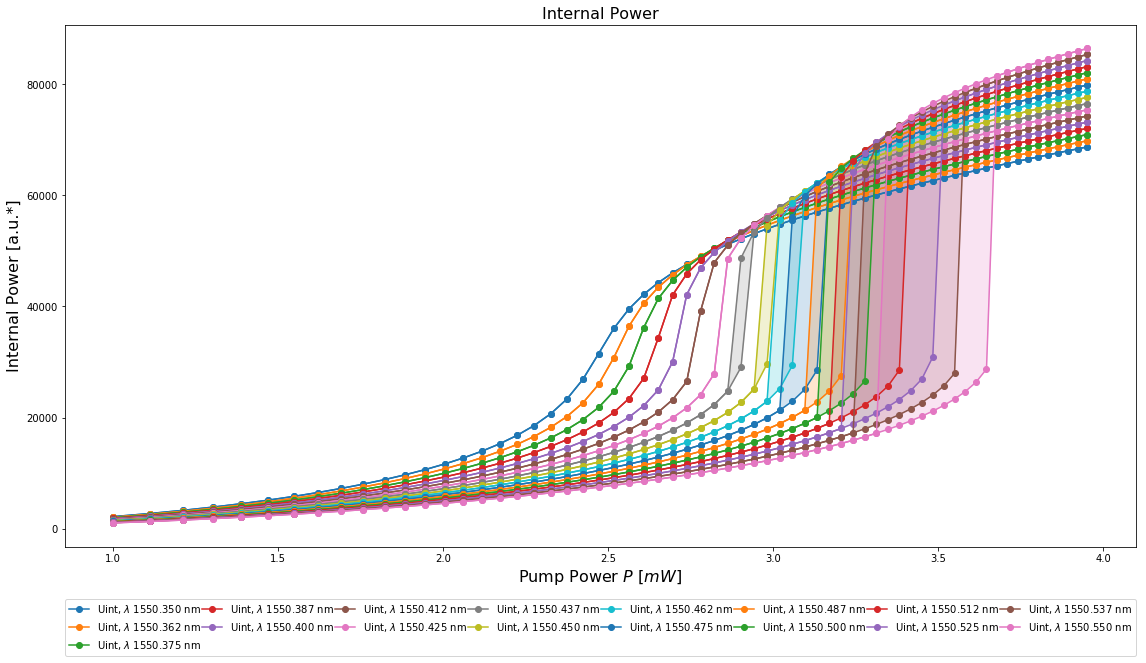

In [6]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_ylim([5e3, 7.5e4])
#ax1.set_xlim([1549, 1551])

ul = []
dl = []
for ω_i in range(ω_size):
    #if E_i <= 3:
        #ax1.plot(E_range[:], np.abs(d['Up'][ω_i,:,0])**2, label='Up, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='-', marker='o')
        ul.append(
            ax1.plot(E_range, u['Ut'][ω_i,:,0], ls='-', marker='o',
                     label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)),
                    )
        )
        dl.append(
            ax1.plot(E_range, d['Ut'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
        )
        upp = u['Ut'][ω_i,:,0]
        downn = d['Ut'][ω_i,:,0]
        ax1.fill_between(E_range, downn, upp, where=downn>=upp, interpolate=True, color=ul[-1][0].get_color(), alpha=0.2)
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0], label='Uint, P %.3f mW'%E_range[E_i]**2, ls='-', marker='o')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,1], label='Uint', ls='--')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,2], label='Uint', ls='-.')
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Us'][:,E_i,0], label='Uint', ls=':')
        
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), d['Ut'][:,E_i,0]-np.mean(d['Ut'][:,E_i,0]), label='Uint, P %.3f'%E_range[E_i]**2 ) 
        #ax1.plot(1e9*f2w(ω_range[:]*ω0,), np.abs(d['Us'][:,E_i,0])**2, label='Us, P %.3fmW'%E_range[E_i]**2)

ax1.set_title( r'Internal Power', fontsize=16)
ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

#tikz_save('test.tex')

plt.show()
plt.close()

In [7]:
#dl = 1e12*f2w(ω_range*ω0) - 1.55e6
dl = (1e12*f2w(ω_range*ω0) - 1.55e6).reshape(np.size(ω_range),1)
dat = d['Ut'][:,:,0]
datt = np.concatenate( (E_range.reshape(np.size(E_range),1).T, dat), axis=0 )
print( np.shape(datt) )

dll = (1e12*f2w(ω_range*ω0) - 1.55e6).reshape(np.size(ω_range),1)
dll2 = ['\t%d'%x for x in np.around(dll) ]
dll3 = 'Power'
for x in dll2:
    dll3 += x
print(dll3)
print()
print( datt[:4,:12].T )

np.savetxt("foo.csv", datt.T, fmt='%.8e', delimiter="\t", header=dll3, comments='')#, newline=' \\')

(18, 64)
Power	350	362	375	387	400	412	425	437	450	462	475	487	500	512	525	537	550

[[1.00000000e+00 2.18213785e+03 2.07153070e+03 1.96829438e+03]
 [1.10996151e+00 2.73206813e+03 2.59075143e+03 2.45914940e+03]
 [1.20997071e+00 3.30135803e+03 3.12692100e+03 2.96487309e+03]
 [1.30232242e+00 3.89175516e+03 3.68146249e+03 3.48662672e+03]
 [1.38854537e+00 4.50526944e+03 4.25599782e+03 4.02572256e+03]
 [1.46971861e+00 5.14422980e+03 4.85238766e+03 4.58365195e+03]
 [1.54663744e+00 5.81135714e+03 5.47278214e+03 5.16212060e+03]
 [1.61990800e+00 6.50985973e+03 6.11968588e+03 5.76309299e+03]
 [1.69000488e+00 7.24355987e+03 6.79604280e+03 6.38884926e+03]
 [1.75730790e+00 8.01706500e+03 7.50534812e+03 7.04205882e+03]
 [1.82212667e+00 8.83600339e+03 8.25179923e+03 7.72587722e+03]
 [1.88471753e+00 9.70735632e+03 9.04050257e+03 8.44407571e+03]]


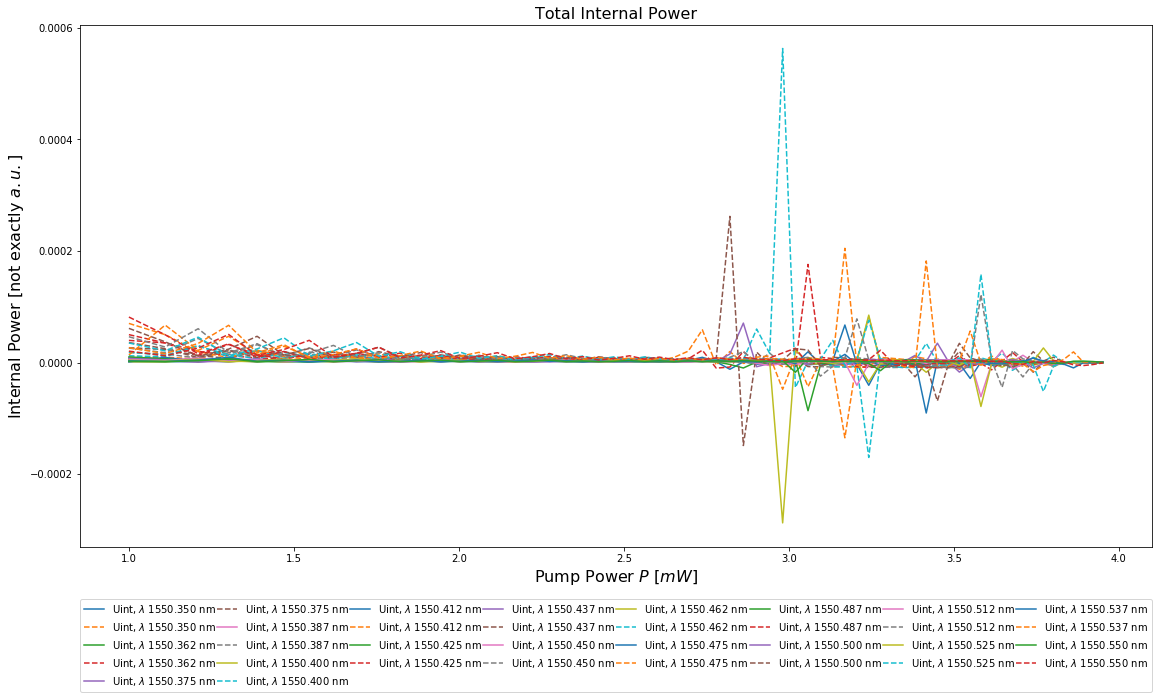

In [8]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])

for ω_i in range(ω_size):
    #if E_i <= 3:
        ax1.plot(E_range, u['Ut'][ω_i,:,0]-u['Ut'][ω_i,:,2], label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)))
        ax1.plot(E_range, u['Ut'][ω_i,:,1]-u['Ut'][ω_i,:,3], label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='--')

ax1.set_title( r'Total Internal Power', fontsize=16)
ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_ylabel(r'Internal Power $[$not exactly $a.u.]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -0.05, 1., -0.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

No handles with labels found to put in legend.


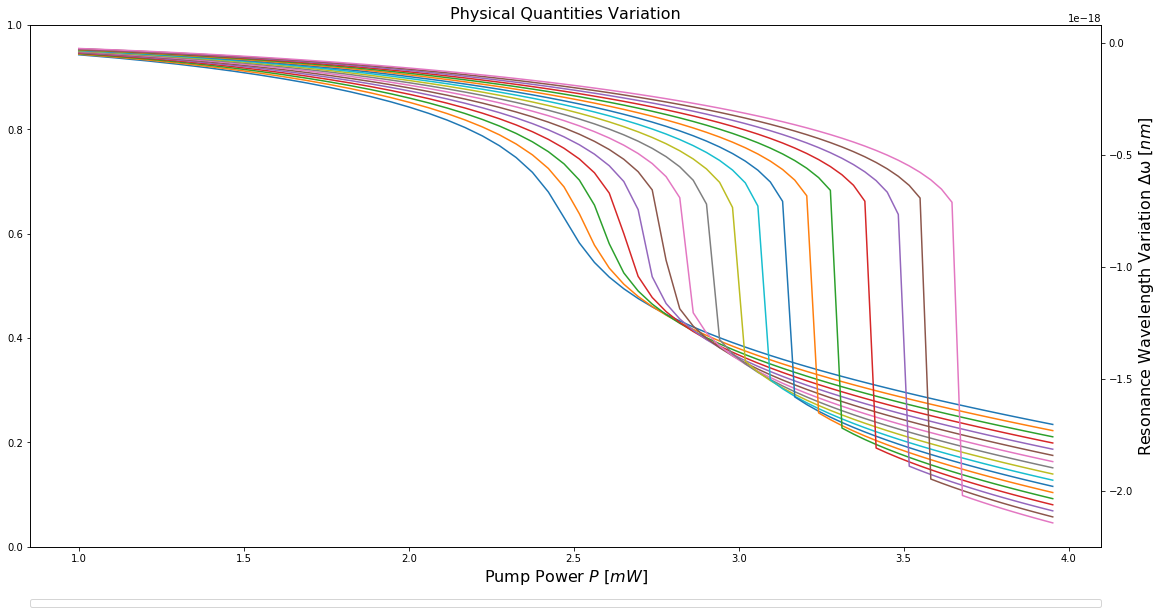

In [9]:
linear = True

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

if not linear:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-20, 1e-2])  

if 0:
    for ω_i in range(ω_size):
        ax1.plot(E_range, u['ΔN'][ω_i,:,0], label='ΔN, $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
    ax1.set_title( r'Population Variation', fontsize=16)
    ax1.set_ylabel(r'Population Variation ΔN $[a.u.]$', fontsize=16)

if 0:
    for ω_i in range(ω_size):
        ax1.plot(E_range, u['ΔT'][ω_i,:,0], label='ΔT, $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
    ax1.set_title( r'Temperature Variation', fontsize=16)
    ax1.set_ylabel(r'Temperature Variation ΔT $[K]$', fontsize=16)

if 1:
    ax2 = ax1.twinx()
    for ω_i in range(ω_size):
        ax2.plot(E_range, np.real(u['Δω'][ω_i,:,0])/ω0, label='RE[Δω], $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)))
#        ax2.plot(E_range, np.imag(u['Δω'][ω_i,:,0])/ω0, label='IM[Δω], $\lambda$ %.3f mW'%(1e9*f2w(ω_range[ω_i]*ω0,)), ls='--')
    #ax2.set_title( r'Resonance Wavelength Variation', fontsize=16)
    ax2.set_title( r'Physical Quantities Variation', fontsize=16)
    ax2.set_ylabel(r'Resonance Wavelength Variation Δω $[nm]$', fontsize=16)
    
#ax2.set_ylabel('sin', color='r')
#ax2.tick_params('y', colors='r')

ax1.set_xlabel(r'Pump Power $P$ $[mW]$', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

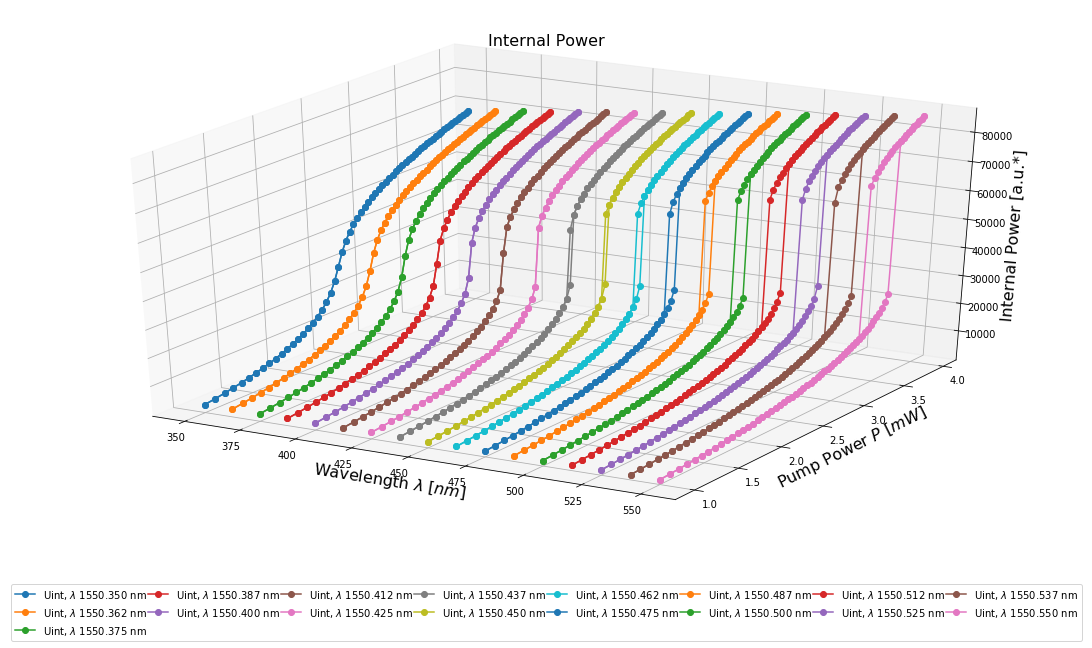

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_title( r'Internal Power', fontsize=16)

#λv, Pv = np.meshgrid( 1e12*f2w(ω_range*ω0)-1.55e6, E_range)

#ax1.plot_surface(λv, Pv, u['Ut'][:,:,0].T)

ul = []
dl = []
for ω_i in range(ω_size):
    ul.append(
        ax1.plot(E_range*0+1e12*f2w(ω_range[ω_i]*ω0)-1.55e6, E_range, u['Ut'][ω_i,:,0], ls='-', marker='o',
                 label='Uint, $\lambda$ %.3f nm'%(1e9*f2w(ω_range[ω_i]*ω0,)),
                )
    )
    dl.append(
        ax1.plot(E_range*0+1e12*f2w(ω_range[ω_i]*ω0)-1.55e6, E_range, d['Ut'][ω_i,:,0], ls='-', marker='o', color=ul[-1][0].get_color() )
    ) 

ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Pump Power $P$ $[mW]$', fontsize=16)
ax1.set_zlabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()